In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from blitz.modules import BayesianLinear, BayesianLinearSVDLayer
from blitz.utils import variational_estimator
import matplotlib.pyplot as plt
# import seaborn as sns

from siren import Sine

from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from torch_truncnorm.TruncatedNormal import TruncatedNormal

from function_collection import *
import matplotlib.pyplot as plt

from functools import partial

# mdmm for constrained optimization
import mdmm

# tensorboard
from torch.utils.tensorboard import SummaryWriter

In [2]:
# create directory for tensorboard logs
import os
if not os.path.exists('benn_1d_regression_section'):
    os.makedirs('benn_1d_regression_section')
    


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


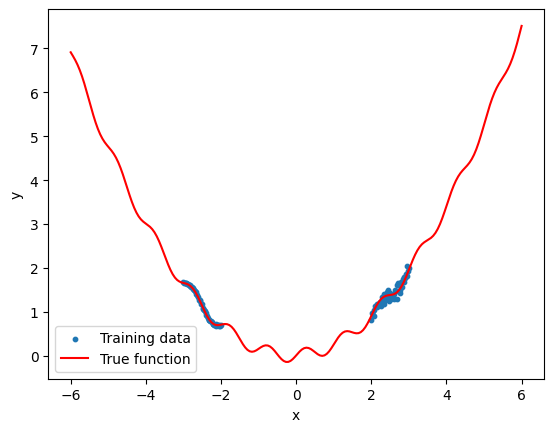

In [4]:
import numpy as np
# Training data
'''
The training data is a polynomial function with noise added to it. 
There are two regions of training data, the first from x = 5 to x = 10
and the second from x = 30 to x = 35. The first one has sigma = 1 
and the second one has sigma = 3.
'''
# Training data
np.random.seed(0)
p0,p1,p2 = 0.2,0.05,0.01
a1 = 0.25
x1 = np.linspace(-3, -2, 50)
y1 =np.polyval([p0,p1,p2], x1) + 0.15*np.sin(2*np.pi*x1) + np.random.normal(0, 0.01, len(x1))

x2 = np.linspace(2.0, 3.0, 50)
y2 = np.polyval([p0,p1,p2], x2) + 0.15*np.sin(2*np.pi*x2) + np.random.normal(0, 0.1, len(x2))

X_train = np.concatenate((x1, x2))
y_train = np.concatenate((y1, y2))

# true function
x_true = np.linspace(-6, 6, 200)
y_true = np.polyval([p0,p1,p2], x_true) + 0.15*np.sin(2*np.pi*x_true)

# Plot the training data
plt.scatter(X_train, y_train, s=10, label='Training data')
plt.plot(x_true, y_true, 'r', label='True function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
# Create dataloader for regression task
X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()

ds_train = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=1000, shuffle=True)


In [5]:
# Periodic Activation Function
class PeriodicActivationFunction(nn.Module):
    def __init__(self, d):
        super(PeriodicActivationFunction, self).__init__()
        # d is the number of terms
        self.d = d
        for i in range(d):
            setattr(self, f'w{i}', nn.Parameter(torch.randn(1)))
            setattr(self, f'b{i}', nn.Parameter(torch.randn(1)))
        
    def forward(self, x):
        result = 0
        for i in range(self.d):
            w = getattr(self, f'w{i}')
            b = getattr(self, f'b{i}')
            result += torch.sin(w*x + b)
        return result



In [6]:
@variational_estimator
class BayesianRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.blinear1 = BayesianLinear(input_dim, 100, bias = True, 
                                       prior_dist = torch.distributions.Normal(torch.tensor(0.0).to(device = torch.device('cuda:0')), 
                                                                               torch.tensor(1.0).to(device = torch.device('cuda:0'))), 
                                       posterior_mu_init = 0.0, posterior_rho_init = -7)
        self.blinear2 = BayesianLinear(100, output_dim, bias = True, prior_dist = torch.distributions.Normal(torch.tensor(0.0).to(device = torch.device('cuda:0')),
                                                                                                              torch.tensor(1.0).to(device = torch.device('cuda:0'))), 
                                       posterior_mu_init = 0.0, posterior_rho_init = -7)
    def forward(self, x):
        x_ = self.blinear1(x)
        x_ = F.relu(x_)
        x = self.blinear2(x_)
        
        x_pred = x[:, 0].unsqueeze(1)
        x_log_noise = x[:, 1].unsqueeze(1)

        # resolve x_log_noise to be positive
        x_log_noise = torch.log1p(torch.exp(x_log_noise))

        return x_pred, x_log_noise
    


### Making arbitrary constraints on the variance


In [121]:
X_test_1 = torch.linspace(-2, 2, 20).view(-1, 1).to(device)
y_test_1 = 2*torch.ones_like(X_test_1).to(device)

X_test_2 = torch.linspace(-4, -6, 20).view(-1, 1).to(device)
y_test_2 = 1.5*torch.ones_like(X_test_2).to(device)

X_test_3 = torch.linspace(4, 6, 20).view(-1, 1).to(device)
y_test_3 = 1.5*torch.ones_like(X_test_3).to(device)


In [122]:
def var_constraint_fn_1(*args, **kwargs):
    model = args[1]
    ale = model(X_test_1.to(device))[1]
    ale_std = ale**0.5
    return ale_std.squeeze()

def var_constraint_fn_2(*args, **kwargs):
    model = args[1]
    ale = model(X_test_2.to(device))[1]
    ale_std = ale**0.5
    return ale_std.squeeze()


def var_constraint_fn_3(*args, **kwargs):
    model = args[1]
    ale = model(X_test_3.to(device))[1]
    ale_std = ale**0.5
    return ale_std.squeeze()



var_constraint_1 = mdmm.EqConstraint(var_constraint_fn_1, y_test_1.squeeze())
var_constraint_2 = mdmm.EqConstraint(var_constraint_fn_2, y_test_2.squeeze())
var_constraint_3 = mdmm.EqConstraint(var_constraint_fn_3, y_test_3.squeeze())
mdmm_module = mdmm.MDMM([var_constraint_1, var_constraint_2, var_constraint_3])


In [123]:
regressor_benn_variance_constraint = BayesianRegressor(1, 2).to(device)
criterion = nn.GaussianNLLLoss()
opt_benn_variance_constraint = optim.Adam(regressor_benn_variance_constraint.parameters(), lr=1e-3)
mse_ = nn.MSELoss(reduce = 'mean')

/home/paralab/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [124]:
best_loss = 1e9
for epoch in range(5000):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        datapoints = datapoints.reshape(-1, 1).to(device)
        labels = labels.reshape(-1, 1).to(device)
        preds, loss_total, loss_data, loss_compleixty = regressor_benn_variance_constraint.sample_elbo_detailed_heteroscedastic_loss(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion,
                           sample_nbr=1,
                           complexity_cost_weight=1/X_train.shape[0])
        mse_loss = mse_(preds[0], labels)
        # opt_benn_valConstraint.zero_grad()
        # loss_total.backward()
        # opt_benn_valConstraint.step()
        # if epoch%10==0:
        #     # print('Epoch:', epoch, 'Iteration:', iteration, 'Loss:', loss_total.item())
        #     print('Epoch:', epoch, 'Total Loss:', loss_total.item(), 'Likelihood Loss:', loss_data.item(), 'Complexity Loss:', loss_compleixty.item())
        
        mdmm_return = mdmm_module(loss_total, regressor_benn_variance_constraint)
        if (torch.hstack(mdmm_return.infs).abs().mean() + mse_loss) < best_loss:
            # check if loss is nan
            best_loss = torch.hstack(mdmm_return.infs).abs().mean() + mse_loss
            # best_model params are saved 
            best_model_benn_variance_constraint = regressor_benn_variance_constraint
            print('Best model updated at epoch:', epoch)
        opt_benn_variance_constraint.zero_grad()
        mdmm_return.value.backward()
        opt_benn_variance_constraint.step()
        if epoch%10==0:
            # print('Epoch:', epoch, 'Iteration:', iteration, 'Loss:', loss_total.item())
            print('Epoch:', epoch, 'Total Loss:', loss_total.item(), 'Likelihood Loss:', loss_data.item(), 'Complexity Loss:', loss_compleixty.item(), 
                  'Infeasibility:', mdmm_return.infs[0].mean().item())


Best model updated at epoch: 0
Epoch: 0 Total Loss: 27.706327438354492 Likelihood Loss: 1.25101900100708 Complexity Loss: 26.45530891418457 Infeasibility: 1.1795257329940796
Best model updated at epoch: 1
Best model updated at epoch: 2
Best model updated at epoch: 3
Best model updated at epoch: 4
Best model updated at epoch: 5
Best model updated at epoch: 6
Best model updated at epoch: 7
Best model updated at epoch: 8
Best model updated at epoch: 9
Best model updated at epoch: 10
Epoch: 10 Total Loss: 26.83268165588379 Likelihood Loss: 0.7694544792175293 Complexity Loss: 26.0632266998291 Infeasibility: 1.1513077020645142
Best model updated at epoch: 11
Best model updated at epoch: 12
Best model updated at epoch: 13
Best model updated at epoch: 14
Best model updated at epoch: 15
Best model updated at epoch: 16
Best model updated at epoch: 17
Best model updated at epoch: 18
Best model updated at epoch: 19
Best model updated at epoch: 20
Epoch: 20 Total Loss: 26.521072387695312 Likelihood

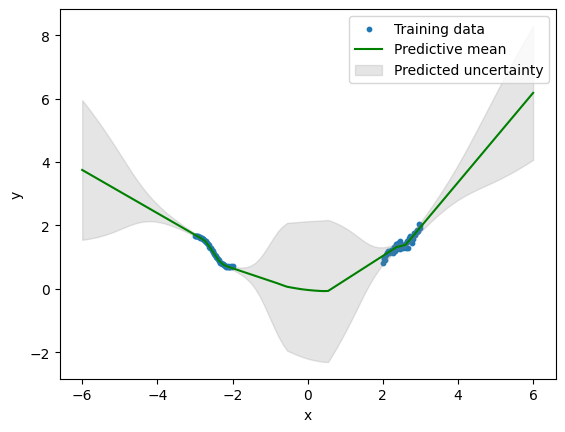

In [125]:
# plotting

best_model_benn_variance_constraint.eval()
X_test = torch.linspace(-6, 6, 100).reshape(-1, 1).to(device)
_, ale = best_model_benn_variance_constraint(X_test)
ale = ale**0.5
preds = [best_model_benn_variance_constraint(X_test) for _ in range(100)]
y_pred = torch.stack([pred[0] for pred in preds], dim=0).mean(dim=0)
std = torch.stack([pred[0] for pred in preds], dim=0).std(dim=0)
std = std.squeeze().detach().cpu().numpy()
y_pred = y_pred.squeeze().detach().cpu().numpy()
ale = ale.squeeze().detach().cpu().numpy()
X_test = X_test.squeeze().cpu().numpy()
plt.figure()
plt.scatter(X_train, y_train, s=10, label='Training data')
plt.plot(X_test, y_pred, 'g', label='Predictive mean')
plt.fill_between(X_test, y_pred-ale, y_pred+ale, color='gray', alpha=0.2, label='Predicted uncertainty')
# plt.fill_between(X_test, y_pred-std, y_pred+std, color='red', alpha=0.2, label='Predicted std')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
# locate the legend on the upper right
plt.legend(loc='upper right')
plt.show()
